# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

In [3]:
#your code here
calendar_train = pd.read_csv('data/calendar_train.csv', parse_dates = ['date'])
calendar_test = pd.read_csv('data/calendar_test.csv', parse_dates = ['date'])

In [4]:
# filter out the no price rows
calendar_train = calendar_train[calendar_train.price.notnull()]
calendar_test = calendar_test[calendar_test.price.notnull()]

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

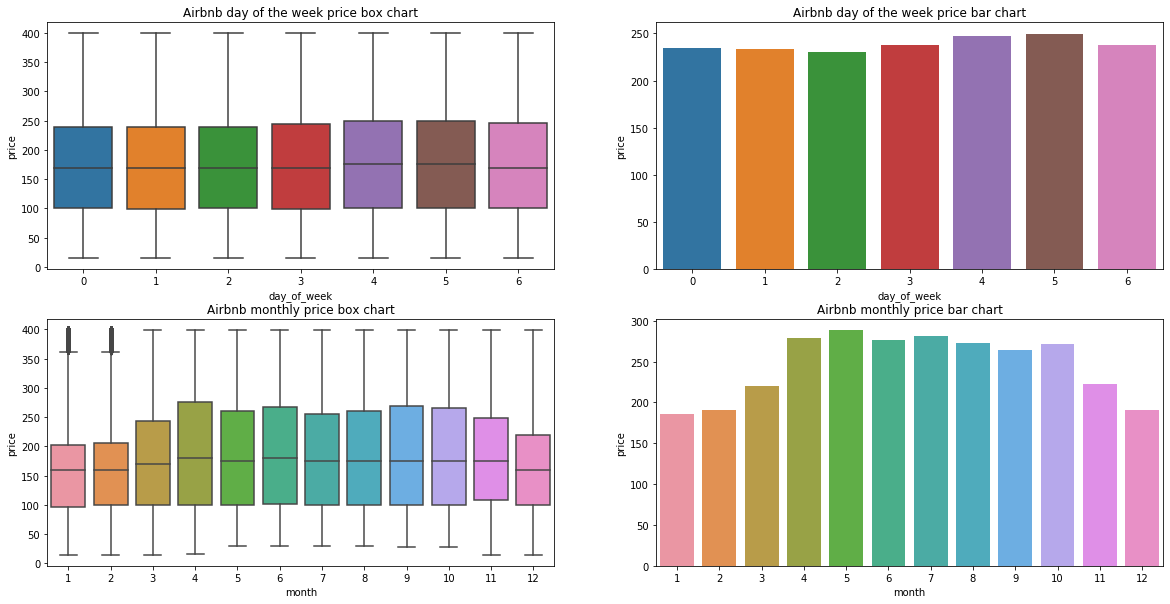

In [5]:
#your code here

calendar_train['day_of_week'] = calendar_train.date.dt.dayofweek
calendar_train['month'] = calendar_train.date.dt.month

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
ax1, ax2, ax3, ax4 = ax.ravel()
sns.boxplot(x="day_of_week", y="price", data=calendar_train.query('price < 400'), ax=ax1).set_title('Airbnb day of the week price box chart')
day_of_week_mean = calendar_train[['day_of_week', 'price']].groupby(['day_of_week']).mean().reset_index()
sns.barplot(x="day_of_week", y="price", data=day_of_week_mean, ax=ax2).set_title('Airbnb day of the week price bar chart')

sns.boxplot(x="month", y="price", data=calendar_train.query('price < 400'), ax=ax3).set_title('Airbnb monthly price box chart')
month_mean = calendar_train[['month', 'price']].groupby(['month']).mean().reset_index()
sns.barplot(x="month", y="price", data=month_mean, ax=ax4).set_title('Airbnb monthly price bar chart')
plt.show()

### Hypothesis on the price trend

based on the charts above, it appears that 
1. the price is generally higher into the weekends especially for Thursday and Fridays, but lower during the week
2. the price is also higher during the summer month, which can be explained by the fact that better weather promotes travel.


### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [6]:
first_date = calendar_train.date.min()
calendar_train['date1'] = (calendar_train['date'] - first_date).astype('timedelta64[D]')
calendar_test['date1'] = (calendar_test['date'] - first_date).astype('timedelta64[D]')

In [54]:
calendar_avg_train = calendar_train[['date1', 'price']].groupby('date1').mean().reset_index()
calendar_avg_test = calendar_test[['date1', 'price']].groupby('date1').mean().reset_index()

In [57]:
for i in range(2, 9):
    predictor_name = 'date' + str(i)
    calendar_avg_train[predictor_name] = calendar_avg_train['date1']**i
    calendar_avg_test[predictor_name] = calendar_avg_test['date1']**i

In [60]:
calendar_avg_train.head()

,date1,price,date2,date3,date4,date5,date6,date7,date8
0,0.0,370.173410,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,409.298701,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2.0,299.128713,4.0,8.0,16.0,32.0,64.0,128.0,256.0
3,3.0,282.768908,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0
4,4.0,275.933202,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0


### 1. Polynomials

In [65]:
#your code here

from sklearn.linear_model import LinearRegression

y_train = calendar_avg_train.price
y_test = calendar_avg_test.price

for degree in [2, 3, 5, 8]:
    cols = [ ('date' + str(i)) for i in range(1, degree+1)]
    X_train = calendar_avg_train[cols]
    X_test = calendar_avg_test[cols]
    reg = LinearRegression().fit(X_train, y_train)
    r2_score_train = reg.score(X_train, y_train)
    r2_score_test = reg.score(X_test, y_test)
    print("%d degree: train R^2 score: %.3f; test R^2 scores %.3f" % (degree, r2_score_train, r2_score_test))

2 degree: train R^2 score: 0.196; test R^2 scores 0.200
3 degree: train R^2 score: 0.638; test R^2 scores 0.614
5 degree: train R^2 score: 0.717; test R^2 scores 0.685
8 degree: train R^2 score: 0.686; test R^2 scores 0.657


_your answer here_


### 2. Degree 8 oddity

When using polynomials, we are explicitly trying to use the higher-order values for a given feature. However, sometimes these polynomial features can take on values that are drastically large, making it difficult for the system to learn an appropriate bias weight due to its large values and potentially large variance. To counter this, sometimes one may be interested in scaling the values for a given feature.

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

y_train = calendar_avg_train.price
y_test = calendar_avg_test.price

for degree in [2, 3, 5, 8]:
    cols = [ ('date' + str(i)) for i in range(1, degree+1)]
    X_train = calendar_avg_train[cols]
    X_test = calendar_avg_test[cols]
    train_copy = pd.DataFrame(X_train.copy())

    # Fit the scaler on the training data
    scaler = StandardScaler().fit(train_copy)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    reg = LinearRegression().fit(X_train, y_train)
    r2_score_train = reg.score(X_train, y_train)
    r2_score_test = reg.score(X_test, y_test)
    print("%d degree: train R^2 score: %.3f; test R^2 scores %.3f" % (degree, r2_score_train, r2_score_test))

2 degree: train R^2 score: 0.196; test R^2 scores 0.200
3 degree: train R^2 score: 0.638; test R^2 scores 0.614
5 degree: train R^2 score: 0.717; test R^2 scores 0.685
8 degree: train R^2 score: 0.737; test R^2 scores 0.702


### with scaling, the polynomial line regression R3 results improved. 

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

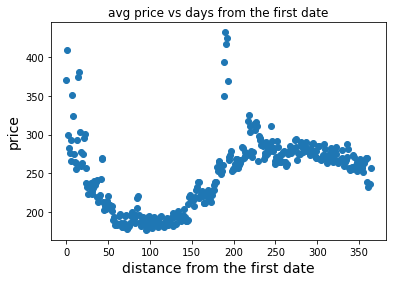

In [174]:
from scipy.interpolate import splev, splrep
from scipy.interpolate import BSpline, CubicSpline
from types import MethodType

X_train = calendar_avg_train[['date1']]
y_train = calendar_avg_train.price
X_test = calendar_avg_test[['date1']]
y_test = calendar_avg_test.price

plt.plot(X_train, y_train, 'o')
plt.title('avg price vs days from the first date')
plt.xlabel('distance from the first date', fontsize=14)
plt.ylabel('price', fontsize=14)

plt.show()

In [169]:
class FitBSpline:
    def __init__(self, t, c, k):
        self.bspline = BSpline(t, c, k)
        
    def fit(self, x, y):
        return self.bspline(x)

    def score(self, x, y):
        return r2_score(self.bspline(x), y)
    
    def get_params(self, deep=True):
        return {"t": self.bspline.t, "c": self.bspline.c, "k": self.bspline.k }
        
s = 0.5 # add smoothing factor
task = 0 # task needs to be set to 0, which represents:
t,c,k = splrep(X_train, y_train, task=task, s=s)
spl = FitBSpline(t, c, k)
score_train = spl.score(X_train, y_train)
score_test = spl.score(X_test, y_test)
print("bspline: train R^2 score: %.3f; test R^2 scores %.3f" % (score_train, score_test))

bspline: train R^2 score: 1.000; test R^2 scores 0.922


In [167]:
from sklearn.model_selection import cross_val_score
for s in np.linspace(0, 1, 11):
    t,c,k = splrep(X_train, y_train, task=task, s=s)
    spl = FitBSpline(t, c, k)
    scores = cross_val_score(spl, X_train, y_train, cv=5)
    print(np.std(scores))


# scores = cross_val_score(spl, X_train, y_train, cv=5)

# scores


0.0
1.431068970485964e-06
1.7904858711618893e-06
2.8357726375358942e-06
5.228895610777349e-06
5.123308467258552e-06
5.147443053125935e-06
7.530580638721924e-06
8.117382808887076e-06
8.738788980910839e-06
9.392957932816038e-06


### 4. Effects of parameters
_your answer here_

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.


In [16]:
#your code here


### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [3]:
#your code here


_your answer here_

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [21]:
#your code here

_your answer here_

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [26]:
#your code here

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


_your answer here_


In [31]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder
#your code here

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)


In [4]:
#your code here

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

_your answer here_